## Bibiliothèque

In [13]:
import numpy as np
import tensorflow as tf;
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from resnet import resnet_layer, resnet_v1, resnet_v2
from Distiller import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
seed = tf.random.set_seed(10)


## Utils

In [14]:
def plot_hist_kd(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['student_loss'], label = "student Loss")
    plt.plot(hist.history['val_student_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [15]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Loading Resnet26 Teacher model

In [16]:
print("")
print("================ Loading teacher model ================")
teacher = tf.keras.models.load_model("Resnet26_from_logits");
print("Evaluation of Teacher model!")
teacher.evaluate(x_test, y_test)
print("")



================ Loading teacher model ================
Evaluation of Teacher model!
313/313 [==============================] - 9s 25ms/step - loss: 0.5328 - sparse_categorical_accuracy: 0.9054



## Creating a data augmentation process

In [17]:
print("================ Building dataGen ================")
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(x_train)

================ Building dataGen ================


## Building a preprocessing routine

In [18]:
print(" ============== Adding preprocessing layers ===============")
preprocessing = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(32, 32, seed= seed),
    tf.keras.layers.RandomFlip(mode="horizontal", seed= seed),

])

 ============== Adding preprocessing layers ===============


## Building Resnet8 Student model 

In [19]:
print("============== Building Student Network Resnet8 ! =============")

student = resnet_v1(input_shape=(32, 32, 3), depth= 8)

student = tf.keras.Sequential([
    preprocessing,
    student,   
])



============== Building Student Network Resnet8 ! =============


## Building callbacks

In [20]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_student_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_student_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)

lr_reduce2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)

## Scratch training

In [21]:
student_scratch = resnet_v2(input_shape=(32, 32, 3), depth= 8)

student_scratch = tf.keras.Sequential([
    preprocessing,
    student_scratch,   
])

In [22]:

BATCH_SIZE = 32
EPOCHS = 100
lr = 0.1

NAME = f"Resnet8_scratch_with_callbacks"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs2/{NAME}", 
                                                 histogram_freq = 1)


student_scratch.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        )

    # Train and evaluate on data.
hist = student_scratch.fit(x_train, y_train, 
      batch_size = BATCH_SIZE,
      epochs=EPOCHS,
      steps_per_epoch = len(x_train)/BATCH_SIZE,
      validation_data =(x_test, y_test),
      workers =40,
      use_multiprocessing= True,
      callbacks = [lr_reduce2, tensorboard],
      )


student_scratch.evaluate(x_test, y_test)

print("")

print("End !")

Epoch 1/100
1562/1562 [==============================] - 58s 36ms/step - loss: 1.5207 - sparse_categorical_accuracy: 0.4721 - val_loss: 2.0182 - val_sparse_categorical_accuracy: 0.4321 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 52s 33ms/step - loss: 1.1833 - sparse_categorical_accuracy: 0.6201 - val_loss: 1.4435 - val_sparse_categorical_accuracy: 0.5484 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 53s 34ms/step - loss: 1.0600 - sparse_categorical_accuracy: 0.6762 - val_loss: 1.2921 - val_sparse_categorical_accuracy: 0.6223 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 53s 34ms/step - loss: 0.9901 - sparse_categorical_accuracy: 0.7113 - val_loss: 1.2712 - val_sparse_categorical_accuracy: 0.6123 - lr: 0.1000
Epoch 5/100
1562/1562 [==============================] - 52s 33ms/step - loss: 0.9512 - sparse_categorical_accuracy: 0.7316 - val_loss: 1.4240 - val_sparse_categorical_accuracy: 0.5669 - lr: 0.1000
Epoch 6/10

Epoch 41/100
1562/1562 [==============================] - 53s 34ms/step - loss: 0.3163 - sparse_categorical_accuracy: 0.9347 - val_loss: 0.5678 - val_sparse_categorical_accuracy: 0.8558 - lr: 1.0000e-03
Epoch 42/100
1562/1562 [==============================] - 53s 34ms/step - loss: 0.2931 - sparse_categorical_accuracy: 0.9446 - val_loss: 0.5636 - val_sparse_categorical_accuracy: 0.8569 - lr: 1.0000e-03
Epoch 43/100
1562/1562 [==============================] - 53s 34ms/step - loss: 0.2851 - sparse_categorical_accuracy: 0.9477 - val_loss: 0.5634 - val_sparse_categorical_accuracy: 0.8542 - lr: 1.0000e-03
Epoch 44/100
1562/1562 [==============================] - 53s 34ms/step - loss: 0.2813 - sparse_categorical_accuracy: 0.9491 - val_loss: 0.5642 - val_sparse_categorical_accuracy: 0.8554 - lr: 1.0000e-03
Epoch 45/100
1562/1562 [==============================] - 52s 34ms/step - loss: 0.2744 - sparse_categorical_accuracy: 0.9517 - val_loss: 0.5639 - val_sparse_categorical_accuracy: 0.8550 - 

Epoch 79/100
1562/1562 [==============================] - 52s 33ms/step - loss: 0.2304 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.5677 - val_sparse_categorical_accuracy: 0.8531 - lr: 1.0000e-06
Epoch 80/100
1562/1562 [==============================] - 53s 34ms/step - loss: 0.2326 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.5664 - val_sparse_categorical_accuracy: 0.8533 - lr: 1.0000e-06
Epoch 81/100
1562/1562 [==============================] - 53s 34ms/step - loss: 0.2304 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.5658 - val_sparse_categorical_accuracy: 0.8536 - lr: 1.0000e-06
Epoch 82/100
1562/1562 [==============================] - 54s 35ms/step - loss: 0.2323 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.5667 - val_sparse_categorical_accuracy: 0.8537 - lr: 1.0000e-06
Epoch 83/100
1562/1562 [==============================] - 53s 34ms/step - loss: 0.2315 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.5667 - val_sparse_categorical_accuracy: 0.8530 - 

## Knowledge distillation

In [25]:
BATCH_SIZE = 32
EPOCHS = 100
A = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lr = 0.1


Epoch 1/100
1562/1562 [==============================] - 81s 49ms/step - sparse_categorical_accuracy: 0.4587 - student_loss: 2.0857 - Dist_loss: 1.1122 - loss: 1.2096 - val_sparse_categorical_accuracy: 0.4942 - val_student_loss: 2.4447 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.6223 - student_loss: 1.7375 - Dist_loss: 0.7677 - loss: 0.8647 - val_sparse_categorical_accuracy: 0.6395 - val_student_loss: 2.4868 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6801 - student_loss: 1.5195 - Dist_loss: 0.6387 - loss: 0.7268 - val_sparse_categorical_accuracy: 0.6291 - val_student_loss: 1.4682 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.7199 - student_loss: 1.3544 - Dist_loss: 0.5552 - loss: 0.6351 - val_sparse_categorical_accuracy: 0.6914 - val_student_loss: 1.4112 - lr: 0.1000
Epoc

Epoch 33/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9219 - student_loss: 0.3149 - Dist_loss: 0.1858 - loss: 0.1987 - val_sparse_categorical_accuracy: 0.8490 - val_student_loss: 1.3424 - lr: 0.0100
Epoch 34/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9212 - student_loss: 0.3093 - Dist_loss: 0.1837 - loss: 0.1963 - val_sparse_categorical_accuracy: 0.8484 - val_student_loss: 1.2947 - lr: 0.0100
Epoch 35/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9202 - student_loss: 0.3098 - Dist_loss: 0.1839 - loss: 0.1965 - val_sparse_categorical_accuracy: 0.8516 - val_student_loss: 1.3073 - lr: 0.0100
Epoch 36/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9216 - student_loss: 0.3045 - Dist_loss: 0.1824 - loss: 0.1946 - val_sparse_categorical_accuracy: 0.8492 - val_student_loss: 1.3252 - lr: 0.0100


Epoch 64/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9359 - student_loss: 0.2390 - Dist_loss: 0.1679 - loss: 0.1750
Epoch 64: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9359 - student_loss: 0.2388 - Dist_loss: 0.1679 - loss: 0.1750 - val_sparse_categorical_accuracy: 0.8507 - val_student_loss: 1.3222 - lr: 1.0000e-04
Epoch 65/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9351 - student_loss: 0.2406 - Dist_loss: 0.1681 - loss: 0.1753 - val_sparse_categorical_accuracy: 0.8514 - val_student_loss: 1.3261 - lr: 1.0000e-05
Epoch 66/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9358 - student_loss: 0.2374 - Dist_loss: 0.1681 - loss: 0.1750 - val_sparse_categorical_accuracy: 0.8513 - val_student_loss: 1.3247 - lr: 1.0000e-05
Epoch 67/100

1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9350 - student_loss: 0.2424 - Dist_loss: 0.1682 - loss: 0.1756 - val_sparse_categorical_accuracy: 0.8506 - val_student_loss: 1.3202 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9360 - student_loss: 0.2371 - Dist_loss: 0.1679 - loss: 0.1749 - val_sparse_categorical_accuracy: 0.8519 - val_student_loss: 1.3232 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9349 - student_loss: 0.2440 - Dist_loss: 0.1688 - loss: 0.1763 - val_sparse_categorical_accuracy: 0.8509 - val_student_loss: 1.3250 - lr: 1.0000e-06
Epoch 97/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9348 - student_loss: 0.2463 - Dist_loss: 0.1686 - loss: 0.1764 - val_sparse_categorical_accuracy: 0.8520 - val_student_loss: 1.3239 - lr: 1.0000e-

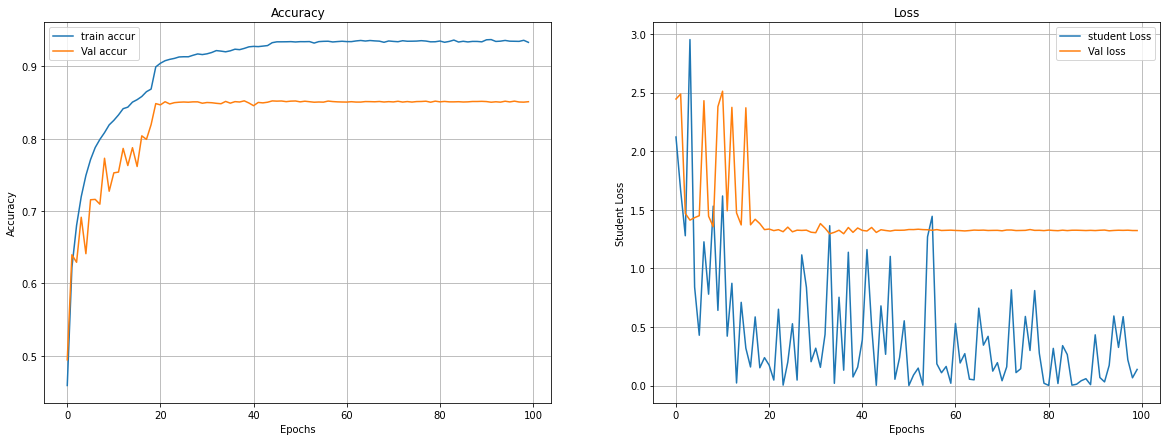

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.1/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 79s 48ms/step - sparse_categorical_accuracy: 0.4529 - student_loss: 1.8088 - Dist_loss: 1.1717 - loss: 1.2991 - val_sparse_categorical_accuracy: 0.4130 - val_student_loss: 1.6844 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.6219 - student_loss: 1.4890 - Dist_loss: 0.8177 - loss: 0.9520 - val_sparse_categorical_accuracy: 0.5075 - val_student_loss: 2.6976 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6776 - student_loss: 1.3153 - Dist_loss: 0.6877 - loss: 0.8132 - val_sparse_categorical_accuracy: 0.6414 - val_student_loss: 1.5496 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.7119 - studen

Epoch 29/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9160 - student_loss: 0.3123 - Dist_loss: 0.2049 - loss: 0.2264 - val_sparse_categorical_accuracy: 0.8446 - val_student_loss: 1.3723 - lr: 1.0000e-03
Epoch 30/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9169 - student_loss: 0.3098 - Dist_loss: 0.2034 - loss: 0.2247 - val_sparse_categorical_accuracy: 0.8439 - val_student_loss: 1.3764 - lr: 1.0000e-03
Epoch 31/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9154 - student_loss: 0.3129 - Dist_loss: 0.2041 - loss: 0.2259 - val_sparse_categorical_accuracy: 0.8428 - val_student_loss: 1.3692 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9180 - student_loss: 0.3026 - Dist_loss: 0.2024 - loss: 0.2224 - val_sparse_categorical_accuracy: 0.8431 - val_student_loss: 1.3697 -

Epoch 59/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9183 - student_loss: 0.2998 - Dist_loss: 0.1998 - loss: 0.2198 - val_sparse_categorical_accuracy: 0.8445 - val_student_loss: 1.3594 - lr: 1.0000e-06
Epoch 60/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9200 - student_loss: 0.2948 - Dist_loss: 0.1989 - loss: 0.2181 - val_sparse_categorical_accuracy: 0.8441 - val_student_loss: 1.3662 - lr: 1.0000e-06
Epoch 61/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9182 - student_loss: 0.2950 - Dist_loss: 0.1996 - loss: 0.2187 - val_sparse_categorical_accuracy: 0.8444 - val_student_loss: 1.3563 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 80s 51ms/step - sparse_categorical_accuracy: 0.9187 - student_loss: 0.3025 - Dist_loss: 0.2000 - loss: 0.2205 - val_sparse_categorical_accuracy: 0.8449 - val_student_loss: 1.3602 -

1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9190 - student_loss: 0.3012 - Dist_loss: 0.1999 - loss: 0.2201 - val_sparse_categorical_accuracy: 0.8440 - val_student_loss: 1.3662 - lr: 1.0000e-06
Epoch 92/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9194 - student_loss: 0.2999 - Dist_loss: 0.1991 - loss: 0.2193 - val_sparse_categorical_accuracy: 0.8452 - val_student_loss: 1.3679 - lr: 1.0000e-06
Epoch 93/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9182 - student_loss: 0.3000 - Dist_loss: 0.2001 - loss: 0.2201 - val_sparse_categorical_accuracy: 0.8432 - val_student_loss: 1.3684 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9173 - student_loss: 0.2983 - Dist_loss: 0.1999 - loss: 0.2196 - val_sparse_categorical_accuracy: 0.8440 - val_student_loss: 1.3637 - lr: 1.0000e-

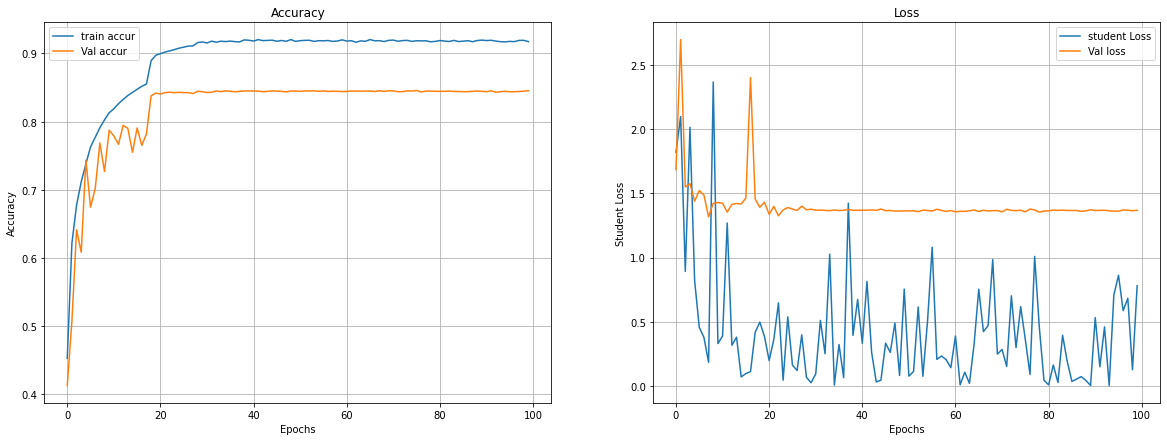

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.2/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 82s 50ms/step - sparse_categorical_accuracy: 0.4572 - student_loss: 1.6548 - Dist_loss: 1.2215 - loss: 1.3515 - val_sparse_categorical_accuracy: 0.4708 - val_student_loss: 2.5131 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6110 - student_loss: 1.3459 - Dist_loss: 0.9023 - loss: 1.0354 - val_sparse_categorical_accuracy: 0.5525 - val_student_loss: 3.5337 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.6665 - student_loss: 1.2013 - Dist_loss: 0.7628 - loss: 0.8943 - val_sparse_categorical_accuracy: 0.6015 - val_student_loss: 1.4002 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.7028 - studen

Epoch 31/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9043 - student_loss: 0.3462 - Dist_loss: 0.2447 - loss: 0.2751 - val_sparse_categorical_accuracy: 0.8351 - val_student_loss: 1.4472 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9022 - student_loss: 0.3496 - Dist_loss: 0.2450 - loss: 0.2764 - val_sparse_categorical_accuracy: 0.8357 - val_student_loss: 1.4470 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9014 - student_loss: 0.3561 - Dist_loss: 0.2459 - loss: 0.2790 - val_sparse_categorical_accuracy: 0.8355 - val_student_loss: 1.4464 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9037 - student_loss: 0.3439 - Dist_loss: 0.2436 - loss: 0.2737
Epoch 34: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 61/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9023 - student_loss: 0.3416 - Dist_loss: 0.2424 - loss: 0.2721 - val_sparse_categorical_accuracy: 0.8348 - val_student_loss: 1.4482 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9038 - student_loss: 0.3404 - Dist_loss: 0.2420 - loss: 0.2715 - val_sparse_categorical_accuracy: 0.8352 - val_student_loss: 1.4486 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9039 - student_loss: 0.3380 - Dist_loss: 0.2417 - loss: 0.2706 - val_sparse_categorical_accuracy: 0.8349 - val_student_loss: 1.4481 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9037 - student_loss: 0.3393 - Dist_loss: 0.2419 - loss: 0.2711 - val_sparse_categorical_accuracy: 0.8348 - val_student_loss: 1.4445 -

1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9023 - student_loss: 0.3426 - Dist_loss: 0.2425 - loss: 0.2725 - val_sparse_categorical_accuracy: 0.8351 - val_student_loss: 1.4449 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9053 - student_loss: 0.3386 - Dist_loss: 0.2414 - loss: 0.2705 - val_sparse_categorical_accuracy: 0.8338 - val_student_loss: 1.4472 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9045 - student_loss: 0.3427 - Dist_loss: 0.2425 - loss: 0.2726 - val_sparse_categorical_accuracy: 0.8351 - val_student_loss: 1.4494 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9041 - student_loss: 0.3447 - Dist_loss: 0.2427 - loss: 0.2733 - val_sparse_categorical_accuracy: 0.8348 - val_student_loss: 1.4474 - lr: 1.0000e-

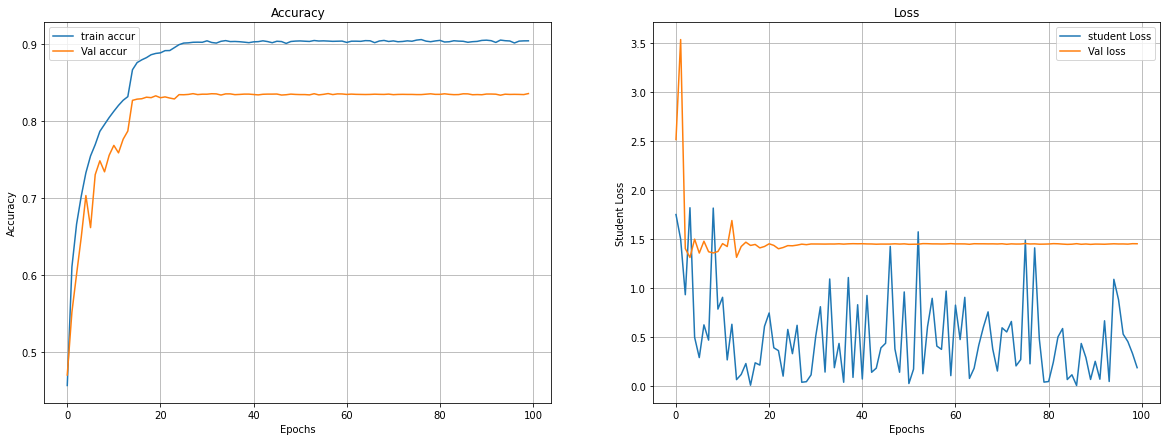

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.3/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 80s 49ms/step - sparse_categorical_accuracy: 0.4573 - student_loss: 1.5626 - Dist_loss: 1.2685 - loss: 1.3861 - val_sparse_categorical_accuracy: 0.4109 - val_student_loss: 2.5957 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6141 - student_loss: 1.2325 - Dist_loss: 0.9537 - loss: 1.0652 - val_sparse_categorical_accuracy: 0.5334 - val_student_loss: 2.6069 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6717 - student_loss: 1.0895 - Dist_loss: 0.8157 - loss: 0.9252 - val_sparse_categorical_accuracy: 0.5352 - val_student_loss: 1.5622 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.7044 - studen

1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.8868 - student_loss: 0.4106 - Dist_loss: 0.2803 - loss: 0.3324 - val_sparse_categorical_accuracy: 0.8103 - val_student_loss: 1.5293 - lr: 0.1000
Epoch 33/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.8852 - student_loss: 0.4079 - Dist_loss: 0.2768 - loss: 0.3293 - val_sparse_categorical_accuracy: 0.7844 - val_student_loss: 1.4232 - lr: 0.1000
Epoch 34/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.8866 - student_loss: 0.4014 - Dist_loss: 0.2719 - loss: 0.3237 - val_sparse_categorical_accuracy: 0.8096 - val_student_loss: 1.4449 - lr: 0.1000
Epoch 35/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8862 - student_loss: 0.4004 - Dist_loss: 0.2719 - loss: 0.3233
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
1562/1562 [==============

Epoch 62/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9512 - student_loss: 0.1491 - Dist_loss: 0.1818 - loss: 0.1687 - val_sparse_categorical_accuracy: 0.8425 - val_student_loss: 1.4453 - lr: 1.0000e-04
Epoch 63/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9521 - student_loss: 0.1504 - Dist_loss: 0.1812 - loss: 0.1689 - val_sparse_categorical_accuracy: 0.8422 - val_student_loss: 1.4436 - lr: 1.0000e-04
Epoch 64/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9507 - student_loss: 0.1516 - Dist_loss: 0.1821 - loss: 0.1699 - val_sparse_categorical_accuracy: 0.8428 - val_student_loss: 1.4467 - lr: 1.0000e-04
Epoch 65/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9508 - student_loss: 0.1527 - Dist_loss: 0.1821 - loss: 0.1704
Epoch 65: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.

1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9510 - student_loss: 0.1499 - Dist_loss: 0.1813 - loss: 0.1688 - val_sparse_categorical_accuracy: 0.8423 - val_student_loss: 1.4472 - lr: 1.0000e-06
Epoch 93/100
1562/1562 [==============================] - 79s 50ms/step - sparse_categorical_accuracy: 0.9506 - student_loss: 0.1482 - Dist_loss: 0.1813 - loss: 0.1681 - val_sparse_categorical_accuracy: 0.8427 - val_student_loss: 1.4454 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9520 - student_loss: 0.1487 - Dist_loss: 0.1813 - loss: 0.1682 - val_sparse_categorical_accuracy: 0.8420 - val_student_loss: 1.4425 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9500 - student_loss: 0.1534 - Dist_loss: 0.1819 - loss: 0.1705 - val_sparse_categorical_accuracy: 0.8428 - val_student_loss: 1.4448 - lr: 1.0000e-

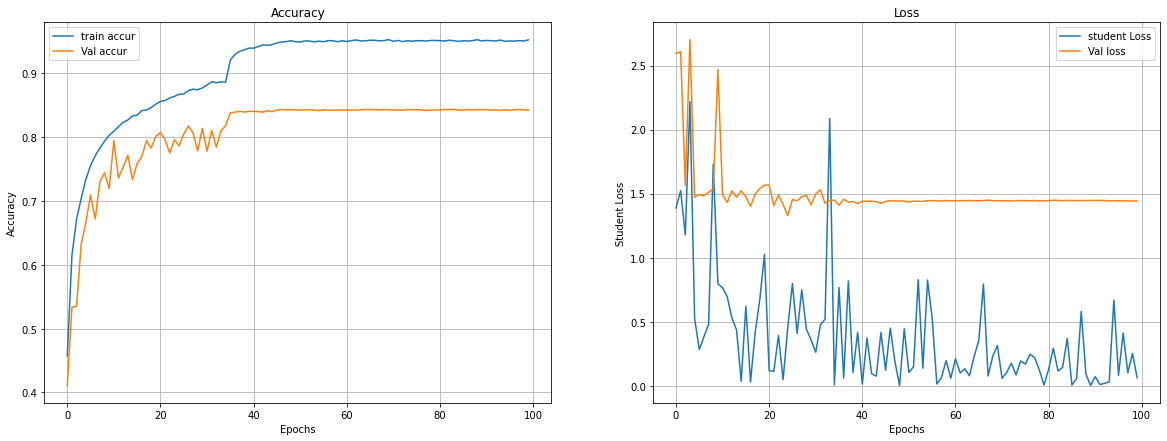

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.4/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 80s 48ms/step - sparse_categorical_accuracy: 0.4644 - student_loss: 1.5009 - Dist_loss: 1.3051 - loss: 1.4030 - val_sparse_categorical_accuracy: 0.3495 - val_student_loss: 4.4697 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6152 - student_loss: 1.1620 - Dist_loss: 1.0081 - loss: 1.0850 - val_sparse_categorical_accuracy: 0.5828 - val_student_loss: 2.5199 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.6711 - student_loss: 1.0271 - Dist_loss: 0.8737 - loss: 0.9504 - val_sparse_categorical_accuracy: 0.6657 - val_student_loss: 1.5028 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.7066 - studen

Epoch 32/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9256 - student_loss: 0.2333 - Dist_loss: 0.2334 - loss: 0.2334 - val_sparse_categorical_accuracy: 0.8431 - val_student_loss: 1.4400 - lr: 0.0100
Epoch 33/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9269 - student_loss: 0.2295 - Dist_loss: 0.2314 - loss: 0.2305 - val_sparse_categorical_accuracy: 0.8428 - val_student_loss: 1.4430 - lr: 0.0100
Epoch 34/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9296 - student_loss: 0.2181 - Dist_loss: 0.2268 - loss: 0.2224 - val_sparse_categorical_accuracy: 0.8403 - val_student_loss: 1.4220 - lr: 0.0100
Epoch 35/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9301 - student_loss: 0.2151 - Dist_loss: 0.2239 - loss: 0.2195 - val_sparse_categorical_accuracy: 0.8392 - val_student_loss: 1.4319 - lr: 0.0100


Epoch 62/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9398 - student_loss: 0.1854 - Dist_loss: 0.2122 - loss: 0.1988 - val_sparse_categorical_accuracy: 0.8404 - val_student_loss: 1.4502 - lr: 1.0000e-05
Epoch 63/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9397 - student_loss: 0.1833 - Dist_loss: 0.2111 - loss: 0.1972 - val_sparse_categorical_accuracy: 0.8406 - val_student_loss: 1.4479 - lr: 1.0000e-05
Epoch 64/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9384 - student_loss: 0.1868 - Dist_loss: 0.2114 - loss: 0.1991 - val_sparse_categorical_accuracy: 0.8403 - val_student_loss: 1.4475 - lr: 1.0000e-05
Epoch 65/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9385 - student_loss: 0.1849 - Dist_loss: 0.2108 - loss: 0.1979 - val_sparse_categorical_accuracy: 0.8414 - val_student_loss: 1.4503 -

1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9399 - student_loss: 0.1811 - Dist_loss: 0.2108 - loss: 0.1960 - val_sparse_categorical_accuracy: 0.8410 - val_student_loss: 1.4486 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9408 - student_loss: 0.1837 - Dist_loss: 0.2112 - loss: 0.1974 - val_sparse_categorical_accuracy: 0.8407 - val_student_loss: 1.4443 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9398 - student_loss: 0.1840 - Dist_loss: 0.2112 - loss: 0.1976 - val_sparse_categorical_accuracy: 0.8404 - val_student_loss: 1.4461 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9381 - student_loss: 0.1875 - Dist_loss: 0.2121 - loss: 0.1998 - val_sparse_categorical_accuracy: 0.8415 - val_student_loss: 1.4443 - lr: 1.0000e-

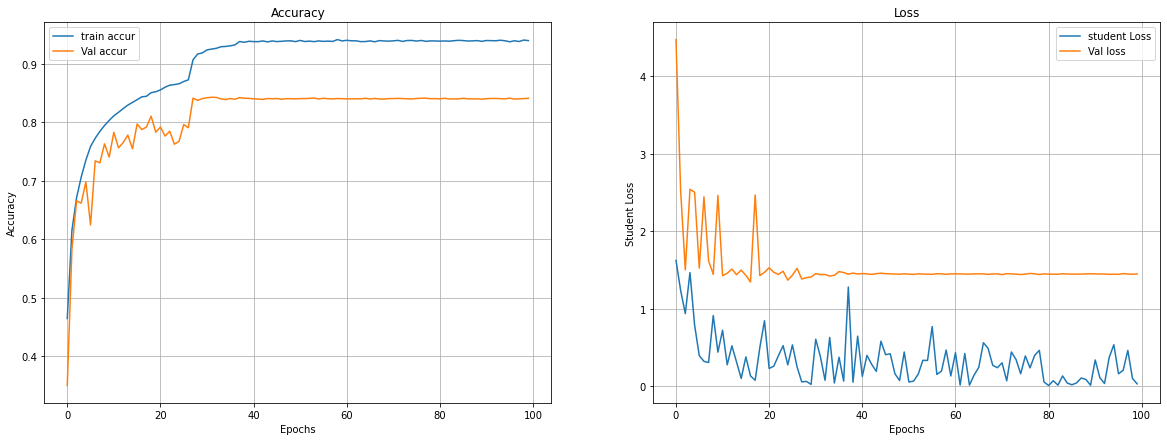

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.5/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 77s 47ms/step - sparse_categorical_accuracy: 0.4612 - student_loss: 1.4788 - Dist_loss: 1.3427 - loss: 1.4244 - val_sparse_categorical_accuracy: 0.5213 - val_student_loss: 2.4041 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.6220 - student_loss: 1.0987 - Dist_loss: 1.0530 - loss: 1.0804 - val_sparse_categorical_accuracy: 0.6049 - val_student_loss: 3.5074 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.6822 - student_loss: 0.9516 - Dist_loss: 0.9127 - loss: 0.9360 - val_sparse_categorical_accuracy: 0.4620 - val_student_loss: 3.4709 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.7154 - studen

1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.8825 - student_loss: 0.3740 - Dist_loss: 0.3254 - loss: 0.3546 - val_sparse_categorical_accuracy: 0.7872 - val_student_loss: 1.3661 - lr: 0.1000
Epoch 33/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.8821 - student_loss: 0.3747 - Dist_loss: 0.3220 - loss: 0.3536 - val_sparse_categorical_accuracy: 0.7941 - val_student_loss: 1.5417 - lr: 0.1000
Epoch 34/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.8867 - student_loss: 0.3607 - Dist_loss: 0.3137 - loss: 0.3419 - val_sparse_categorical_accuracy: 0.8037 - val_student_loss: 1.4245 - lr: 0.1000
Epoch 35/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.8850 - student_loss: 0.3637 - Dist_loss: 0.3131 - loss: 0.3435 - val_sparse_categorical_accuracy: 0.8039 - val_student_loss: 1.5223 - lr: 0.1000
Epoch 36/100


1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9613 - student_loss: 0.1100 - Dist_loss: 0.1876 - loss: 0.1411 - val_sparse_categorical_accuracy: 0.8398 - val_student_loss: 1.4200 - lr: 1.0000e-03
Epoch 63/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9619 - student_loss: 0.1102 - Dist_loss: 0.1868 - loss: 0.1408 - val_sparse_categorical_accuracy: 0.8401 - val_student_loss: 1.4206 - lr: 1.0000e-04
Epoch 64/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9616 - student_loss: 0.1102 - Dist_loss: 0.1879 - loss: 0.1413 - val_sparse_categorical_accuracy: 0.8394 - val_student_loss: 1.4158 - lr: 1.0000e-04
Epoch 65/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9614 - student_loss: 0.1092 - Dist_loss: 0.1874 - loss: 0.1405 - val_sparse_categorical_accuracy: 0.8402 - val_student_loss: 1.4227 - lr: 1.0000e-

1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9636 - student_loss: 0.1073 - Dist_loss: 0.1870 - loss: 0.1392 - val_sparse_categorical_accuracy: 0.8396 - val_student_loss: 1.4189 - lr: 1.0000e-06
Epoch 93/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9624 - student_loss: 0.1079 - Dist_loss: 0.1871 - loss: 0.1396 - val_sparse_categorical_accuracy: 0.8397 - val_student_loss: 1.4179 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9621 - student_loss: 0.1077 - Dist_loss: 0.1868 - loss: 0.1393 - val_sparse_categorical_accuracy: 0.8394 - val_student_loss: 1.4245 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9620 - student_loss: 0.1080 - Dist_loss: 0.1875 - loss: 0.1398 - val_sparse_categorical_accuracy: 0.8396 - val_student_loss: 1.4243 - lr: 1.0000e-

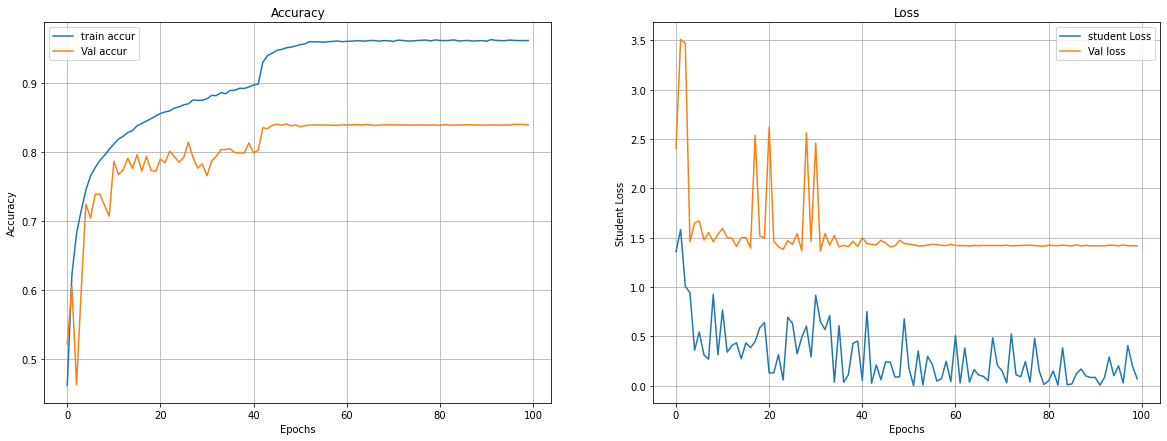

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.6/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 80s 48ms/step - sparse_categorical_accuracy: 0.4585 - student_loss: 1.4883 - Dist_loss: 1.3901 - loss: 1.4588 - val_sparse_categorical_accuracy: 0.4055 - val_student_loss: 3.4978 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.6146 - student_loss: 1.1038 - Dist_loss: 1.1270 - loss: 1.1107 - val_sparse_categorical_accuracy: 0.5894 - val_student_loss: 3.5188 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.6735 - student_loss: 0.9464 - Dist_loss: 0.9924 - loss: 0.9602 - val_sparse_categorical_accuracy: 0.6152 - val_student_loss: 2.4860 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.7122 - studen

1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9072 - student_loss: 0.2728 - Dist_loss: 0.3353 - loss: 0.2915 - val_sparse_categorical_accuracy: 0.8256 - val_student_loss: 1.4432 - lr: 0.0100
Epoch 32/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9133 - student_loss: 0.2540 - Dist_loss: 0.3283 - loss: 0.2763 - val_sparse_categorical_accuracy: 0.8304 - val_student_loss: 1.4491 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9142 - student_loss: 0.2507 - Dist_loss: 0.3260 - loss: 0.2733 - val_sparse_categorical_accuracy: 0.8319 - val_student_loss: 1.4419 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9147 - student_loss: 0.2481 - Dist_loss: 0.3241 - loss: 0.2709 - val_sparse_categorical_accuracy: 0.8326 - val_student_loss: 1.4472 - lr: 1.0000e-03
E

1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9180 - student_loss: 0.2369 - Dist_loss: 0.3178 - loss: 0.2612
Epoch 61: ReduceLROnPlateau reducing learning rate to 1e-06.
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9179 - student_loss: 0.2379 - Dist_loss: 0.3179 - loss: 0.2619 - val_sparse_categorical_accuracy: 0.8317 - val_student_loss: 1.4528 - lr: 1.0000e-05
Epoch 62/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9180 - student_loss: 0.2435 - Dist_loss: 0.3179 - loss: 0.2658 - val_sparse_categorical_accuracy: 0.8312 - val_student_loss: 1.4556 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9185 - student_loss: 0.2440 - Dist_loss: 0.3183 - loss: 0.2663 - val_sparse_categorical_accuracy: 0.8322 - val_student_loss: 1.4540 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [=================

1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9168 - student_loss: 0.2412 - Dist_loss: 0.3182 - loss: 0.2643 - val_sparse_categorical_accuracy: 0.8315 - val_student_loss: 1.4497 - lr: 1.0000e-06
Epoch 93/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9164 - student_loss: 0.2421 - Dist_loss: 0.3178 - loss: 0.2648 - val_sparse_categorical_accuracy: 0.8314 - val_student_loss: 1.4464 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9170 - student_loss: 0.2395 - Dist_loss: 0.3178 - loss: 0.2630 - val_sparse_categorical_accuracy: 0.8309 - val_student_loss: 1.4542 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9173 - student_loss: 0.2412 - Dist_loss: 0.3176 - loss: 0.2641 - val_sparse_categorical_accuracy: 0.8319 - val_student_loss: 1.4461 - lr: 1.0000e-

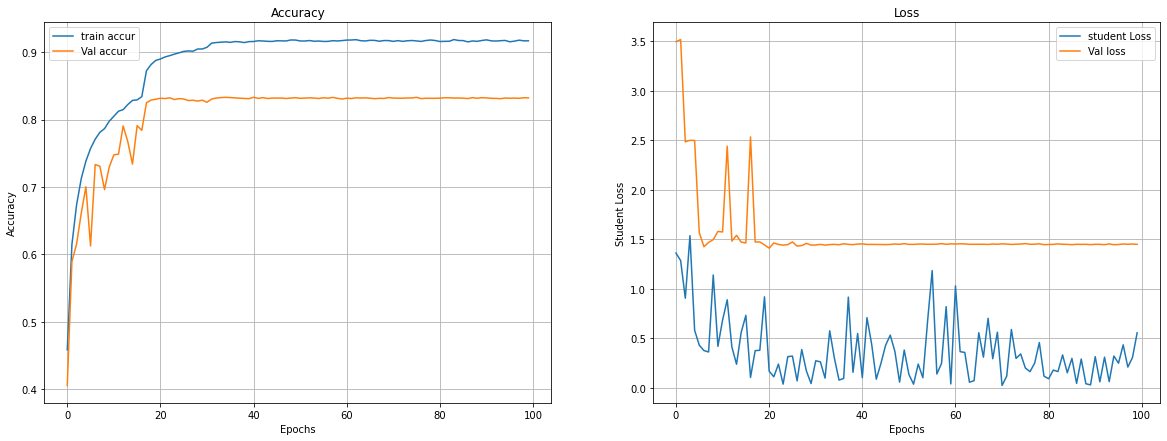

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.7/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 79s 48ms/step - sparse_categorical_accuracy: 0.4707 - student_loss: 1.4468 - Dist_loss: 1.3936 - loss: 1.4362 - val_sparse_categorical_accuracy: 0.4924 - val_student_loss: 2.4696 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.6237 - student_loss: 1.0591 - Dist_loss: 1.1443 - loss: 1.0761 - val_sparse_categorical_accuracy: 0.5609 - val_student_loss: 2.5931 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6818 - student_loss: 0.9082 - Dist_loss: 1.0214 - loss: 0.9309 - val_sparse_categorical_accuracy: 0.6462 - val_student_loss: 1.4423 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.7202 - studen

Epoch 31/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9172 - student_loss: 0.2431 - Dist_loss: 0.3668 - loss: 0.2678 - val_sparse_categorical_accuracy: 0.8374 - val_student_loss: 1.5304 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9174 - student_loss: 0.2372 - Dist_loss: 0.3657 - loss: 0.2629 - val_sparse_categorical_accuracy: 0.8402 - val_student_loss: 1.5216 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9163 - student_loss: 0.2424 - Dist_loss: 0.3640 - loss: 0.2667 - val_sparse_categorical_accuracy: 0.8381 - val_student_loss: 1.5206 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9190 - student_loss: 0.2398 - Dist_loss: 0.3624 - loss: 0.2643 - val_sparse_categorical_accuracy: 0.8386 - val_student_loss: 1.5292 -

Epoch 61/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9187 - student_loss: 0.2349 - Dist_loss: 0.3591 - loss: 0.2597 - val_sparse_categorical_accuracy: 0.8391 - val_student_loss: 1.5235 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9179 - student_loss: 0.2377 - Dist_loss: 0.3599 - loss: 0.2622 - val_sparse_categorical_accuracy: 0.8387 - val_student_loss: 1.5243 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9186 - student_loss: 0.2358 - Dist_loss: 0.3592 - loss: 0.2605 - val_sparse_categorical_accuracy: 0.8392 - val_student_loss: 1.5253 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 77s 50ms/step - sparse_categorical_accuracy: 0.9195 - student_loss: 0.2341 - Dist_loss: 0.3593 - loss: 0.2592 - val_sparse_categorical_accuracy: 0.8383 - val_student_loss: 1.5243 -

1562/1562 [==============================] - 79s 51ms/step - sparse_categorical_accuracy: 0.9204 - student_loss: 0.2365 - Dist_loss: 0.3596 - loss: 0.2611 - val_sparse_categorical_accuracy: 0.8386 - val_student_loss: 1.5205 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 77s 50ms/step - sparse_categorical_accuracy: 0.9185 - student_loss: 0.2358 - Dist_loss: 0.3594 - loss: 0.2605 - val_sparse_categorical_accuracy: 0.8390 - val_student_loss: 1.5241 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9204 - student_loss: 0.2316 - Dist_loss: 0.3585 - loss: 0.2570 - val_sparse_categorical_accuracy: 0.8388 - val_student_loss: 1.5268 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9189 - student_loss: 0.2363 - Dist_loss: 0.3597 - loss: 0.2610 - val_sparse_categorical_accuracy: 0.8380 - val_student_loss: 1.5211 - lr: 1.0000e-

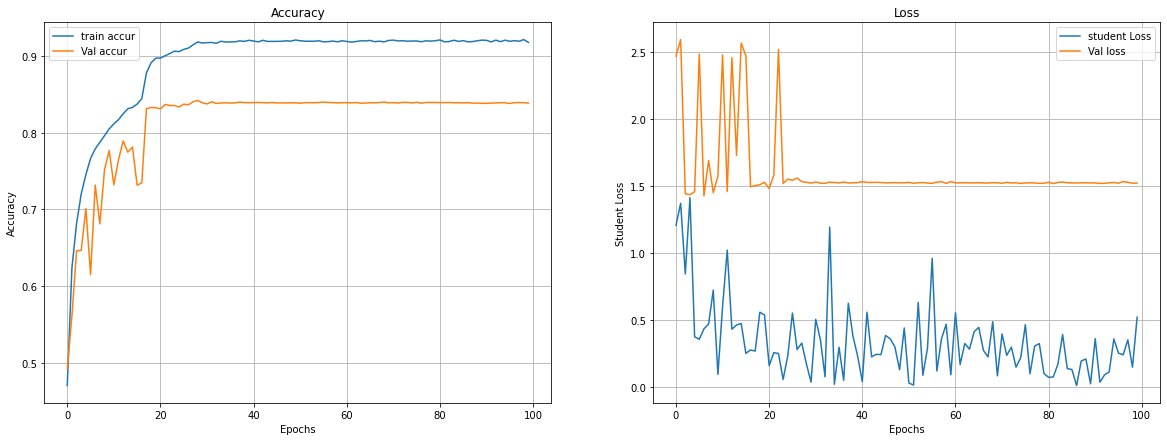

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.8/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 84s 51ms/step - sparse_categorical_accuracy: 0.4694 - student_loss: 1.4432 - Dist_loss: 1.4135 - loss: 1.4403 - val_sparse_categorical_accuracy: 0.4383 - val_student_loss: 2.4597 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.6268 - student_loss: 1.0500 - Dist_loss: 1.1848 - loss: 1.0635 - val_sparse_categorical_accuracy: 0.6218 - val_student_loss: 2.4471 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6844 - student_loss: 0.8931 - Dist_loss: 1.0700 - loss: 0.9108 - val_sparse_categorical_accuracy: 0.5968 - val_student_loss: 2.2693 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.7221 - studen

Epoch 32/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9236 - student_loss: 0.2160 - Dist_loss: 0.3939 - loss: 0.2338 - val_sparse_categorical_accuracy: 0.8346 - val_student_loss: 1.4219 - lr: 0.0100
Epoch 33/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9239 - student_loss: 0.2160 - Dist_loss: 0.3863 - loss: 0.2330 - val_sparse_categorical_accuracy: 0.8353 - val_student_loss: 1.4191 - lr: 0.0100
Epoch 34/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9257 - student_loss: 0.2107 - Dist_loss: 0.3818 - loss: 0.2278
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9257 - student_loss: 0.2113 - Dist_loss: 0.3820 - loss: 0.2284 - val_sparse_categorical_accuracy: 0.8367 - val_student_loss: 1.4516 - lr: 0.0100
Epoch 35/100
1562/1562 [

1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9318 - student_loss: 0.1907 - Dist_loss: 0.3648 - loss: 0.2081 - val_sparse_categorical_accuracy: 0.8381 - val_student_loss: 1.4259 - lr: 1.0000e-05
Epoch 62/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9346 - student_loss: 0.1901 - Dist_loss: 0.3652 - loss: 0.2076 - val_sparse_categorical_accuracy: 0.8381 - val_student_loss: 1.4279 - lr: 1.0000e-05
Epoch 63/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9336 - student_loss: 0.1910 - Dist_loss: 0.3654 - loss: 0.2085 - val_sparse_categorical_accuracy: 0.8379 - val_student_loss: 1.4286 - lr: 1.0000e-05
Epoch 64/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9333 - student_loss: 0.1893 - Dist_loss: 0.3653 - loss: 0.2069
Epoch 64: ReduceLROnPlateau reducing learning rate to 1e-06.
1562/1562 [=================

1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9339 - student_loss: 0.1896 - Dist_loss: 0.3649 - loss: 0.2071 - val_sparse_categorical_accuracy: 0.8377 - val_student_loss: 1.4292 - lr: 1.0000e-06
Epoch 93/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9353 - student_loss: 0.1874 - Dist_loss: 0.3645 - loss: 0.2051 - val_sparse_categorical_accuracy: 0.8379 - val_student_loss: 1.4366 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9351 - student_loss: 0.1873 - Dist_loss: 0.3642 - loss: 0.2050 - val_sparse_categorical_accuracy: 0.8380 - val_student_loss: 1.4267 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9347 - student_loss: 0.1879 - Dist_loss: 0.3652 - loss: 0.2056 - val_sparse_categorical_accuracy: 0.8378 - val_student_loss: 1.4306 - lr: 1.0000e-

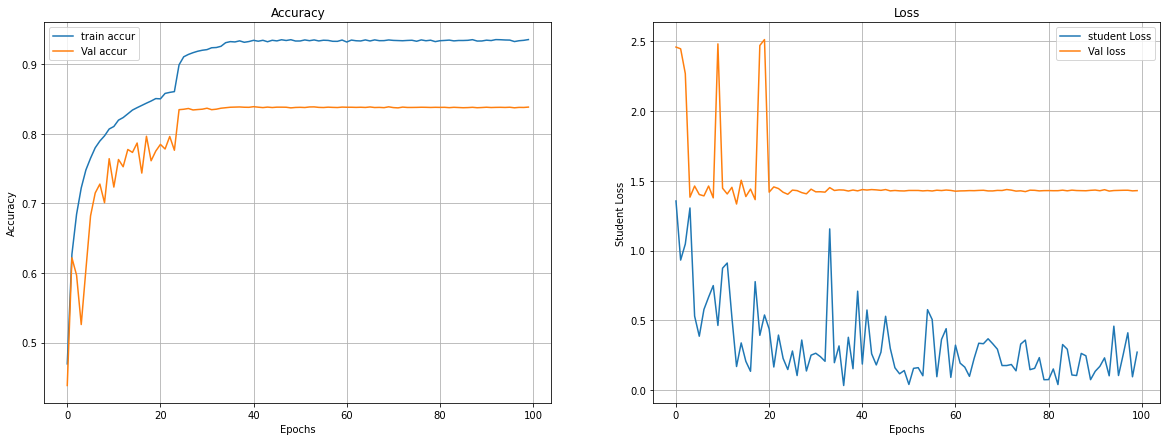

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.9/assets
Saving Done !
Saving Weights 
Saving Done !

End !


In [26]:
for a in A:
    # Configuration du tensorboard
    NAME = f"Resnet8_kd_alpha_{a}_temp_{5}"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs2/{NAME}", 
                                                 histogram_freq = 1)
    
    student_test = tf.keras.models.clone_model(student)

    dist = Distiller(teacher, student_test)

    dist.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        alpha = a,
        temperature = 5)

    # Train and evaluate on data.
    hist = dist.fit(x_train, y_train, 
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          callbacks = [lr_reduce, tensorboard],
          )


    dist.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist_kd(hist, f"Resnet8_KD_notebook_alpha{a}.png")


    print("Saving model ")
    student_test.save(f"Resnet8_KD_notebook_alpha{a}")
    print("Saving Done !")

    print("Saving Weights ")
    student_test.save_weights(f"w_resnet8_alpha_{a}.h5")
    print("Saving Done !")
    print("")

    print("End !")